In [7]:
import ee

try:
    ee.Initialize(project='ee-gsingh')
except:
    ee.Authenticate()
    ee.Initialize(project='ee-gsingh')

from geeml.utils import eeprint
    

# plot the distribution of fire event duration
fired = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")

durationList = fired.aggregate_array('event_dur').getInfo()


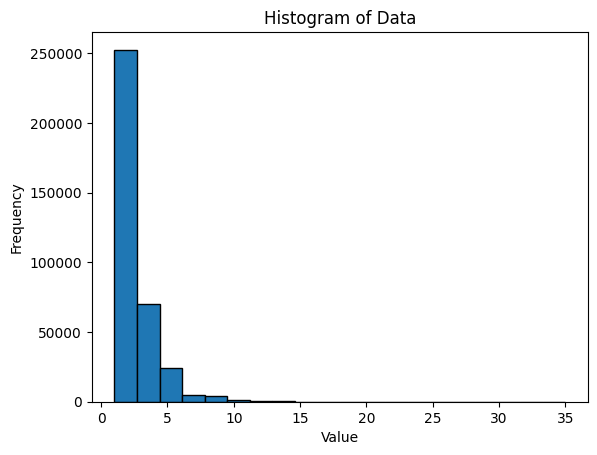

In [9]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(durationList, bins=20, edgecolor='black')

# Labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Show plot
plt.show()


In [ ]:
# Extract Landsat data for pretraining
# for 1000 polygons download landsat and other dataset labels.
# copy annotations from disk
# prepare data

In [15]:
# Supported sensors and radiometric corrections 
supportedSensors = {'Sentinel-1': ee.ImageCollection('COPERNICUS/S1_GRD'),
                    'Sentinel-2': ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED"),
                    'LANDSAT_8': ee.ImageCollection("LANDSAT/LC08/C02/T1_L2"),
                    'LANDSAT_9': ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")}

def preprocessOptical(image, sensor):
    """Select Bands and scale between 0 and 1
    """
    bandSelect = {'Sentinel-2': 'B.*',
                    'LANDSAT_8': 'SR_B.',
                    'LANDSAT_9': 'SR_B.'}
    # Step 2) radiometric correction
    radiometricMultiplySelect = {'Sentinel-2': 0.0001,
                    'LANDSAT_8': 0.0000275,
                    'LANDSAT_9': 0.0000275}
    radiometricAddSelect = {'Sentinel-2': 0,
                    'LANDSAT_8': -0.2,
                    'LANDSAT_9': -0.2}
    
    # Step 3) depending on image selected, select cloud band
    return image.select(bandSelect.get(sensor)).multiply(radiometricMultiplySelect.get(sensor)).add(radiometricAddSelect.get(sensor)).copyProperties(image)


In [16]:
# Landsat data exploration
def cloudMask1(image):
    clouds = image.select('QA_PIXEL').bitwiseAnd(0b1000).eq(0)
    cirrus = image.select('QA_PIXEL').bitwiseAnd(0b1100).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    #   Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    #  Replace the original bands with the scaled ones and apply the masks.
    return opticalBands\
        .updateMask(clouds)\
        .updateMask(cirrus)\
        .updateMask(saturationMask)

def cloudMask2(image):
    clouds = image.select('QA_PIXEL').bitwiseAnd(0b1000).eq(0)
    cirrus = image.select('QA_PIXEL').bitwiseAnd(0b1100).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    #   Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Compute normalised burn ratio (NBR)
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('nbr')

    #  Replace the original bands with the scaled ones and apply the masks.
    return opticalBands.addBands([nbr], None, True)\
        .updateMask(clouds)\
        .updateMask(cirrus)\
        .updateMask(saturationMask)
def qualityMosaicPercentile(collection, QAband, percentile):
    # Compute percentile image
    percentileImage = collection.select(QAband).reduce(ee.Reducer.percentile([percentile]))
    #  Compute distance of every pixel from the computed percentile in that location
    withDist = ee.ImageCollection(collection.map(lambda image: image.addBands([
        image.select(QAband).subtract(percentileImage).abs().multiply(-1).rename('quality')])))
    return withDist.qualityMosaic('quality')

In [17]:
def getImage(sensor, pre, event, dateBuffer):
    """
    Get the temporally closest pre-fire and post-fire optical or radar images after preprocessing both
    the optical images.

    Args:
        event (ee.Feature): A fire event delineating the boundary of burnt area
        dateBuffer (int): The temporal window to locate a relevant image. In units of weeks.

    Returns:
        A pre-fire and post-fire optical or radar image
    """
    # Filter images that intersect the geometry using the optimised filterBounds. Thereafter, use the
    # ee.filter.contains that is not as optimised as filterBounds
    images = supportedSensors.get(sensor).filterBounds(event.geometry())
    eventDate = ee.Date(event.get('Ig_Date'))
    if pre:
        startDate = eventDate.advance(dateBuffer*-1, 'week')
        endDate = eventDate
        outImage = images.filterDate(startDate, endDate).sort('system:time_start', False).map(lambda img: cloudMask1(img)).reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', False).first()

    else:
        # postfire
        startDate = eventDate
        endDate = eventDate.advance(dateBuffer, 'week')
        outImage = images.filterDate(startDate, endDate).map(lambda img: cloudMask2(img))#.reduce(ee.Reducer.firstNonNull()).regexpRename('.{6}$','')#.qualityMosaic('nbr')
        # .filter(ee.Filter.contains('.geo', event.geometry())).sort('system:time_start', True).first()
    
    return outImage

    # Given a fire event get pre and post fire image from multi-sensors
def getOpticalRadarPairs(sensor:str, dnbr:bool, event: ee.Feature, dateBuffer: int = 4)-> ee.Image:
    """
    Get optical-radar pairs for a given fire event. First image after fire event and image before fire event

    Args:
        sensor(str): The name of the sensor. One of ['Sentinel-1', 'Sentinel-2', 'Landsat_8', 'Landsat_9']
        event(ee.Feature): A fire event
        dateBuffer(int): The temporal-search window. 
    
    Returns:
        An image with optical-radar pairs

    """
    # Post-fire image
    postOpticalImage = getImage(sensor, False, event, dateBuffer= dateBuffer)
    # pre-fire
    preOpticalImage = getImage(sensor, True, event, dateBuffer= dateBuffer)

    # if sensor == 'Sentinel-1':
    #     # RADAR
    #     s1post = getImage('Sentinel-1', False, event, dateBuffer= dateBuffer)
    #     # preprocess pre-fire radar image
    #     parameters.update({'STOP_DATE': s1post.date().advance(1, 'day'), 'START_DATE': s1post.date(), 'ROI': event.geometry()})
    #     s1post = wp.s1_preproc(parameters).select('V.')
    
    if sensor == 'Sentinel-2':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['B8A', 'B12']).subtract(img.normalizedDifference(['B8A', 'B12'])).rename('dnbr'))), 'dnbr', 95) 
    if sensor == 'LANDSAT_8' or sensor == 'LANDSAT_9':
        postOpticalImage = qualityMosaicPercentile(postOpticalImage.map(lambda img: img.addBands(
            preOpticalImage.normalizedDifference(['SR_B5', 'SR_B7']).subtract(img.normalizedDifference(['SR_B5', 'SR_B7'])).rename('dnbr'))), 'dnbr', 95)
    return postOpticalImage
    

In [18]:
def prepareLabel(event: ee.Feature, patchSize: int, scale: int)-> ee.Image:
    """
    Converts a burn area polygon (ee.Feature) to a raster label. Burnt pixels are assigned a value of 1.
    Unburnt pixels are assigned a value of 0. the returned ee.Image dimensions should closely approximate
    the number of pixels divisible by the patchSize.

    Args:
        event(ee.Feature): The delineated burn area polygon to rasterize.
        patchSize (int): The desirable patch dimension when training the DNN model.
        scale (int): The desired output scale for the label.

    Returns:
        The rasterised label (ee.Image)
    """
    # Define the WKT string for EPSG:102005
    wkt = ('PROJCS["USA_Contiguous_Equidistant_Conic",'
        'GEOGCS["GCS_North_American_1983",'
        'DATUM["D_North_American_1983",'
        'SPHEROID["GRS_1980",6378137.0,298.257222101]],'
        'PRIMEM["Greenwich",0.0],'
        'UNIT["Degree",0.0174532925199433]],'
        'PROJECTION["Equidistant_Conic"],'
        'PARAMETER["False_Easting",0.0],'
        'PARAMETER["False_Northing",0.0],'
        'PARAMETER["longitude_of_center",-96.0],'
        'PARAMETER["Standard_Parallel_1",33.0],'
        'PARAMETER["Standard_Parallel_2",45.0],'
        'PARAMETER["latitude_of_center",39.0],'
        'UNIT["Meter",1.0]]')

    # Create the ee.Projection object
    projection = ee.Projection(wkt)
    
    # Create a covering grid using the equal-distance projection. each cell is 1 patch
    covering_grid = event.geometry().coveringGrid(projection, patchSize*scale).geometry().bounds(scale*0.9)
    
    # Return binary label, 1= burn pixels, 0 = unburnt pixels
    extent = ee.Image.constant(1).clip(covering_grid)
    burnt = ee.Image.constant(1).clip(event.geometry())
        
    label = extent.updateMask(burnt).unmask(0)
    return label.rename('label')

In [ ]:
rootdir = "/home/geethen/fire/data/DNN/L8"


for id in tqdm(range(8226, mtbs_sz)):#mtbs_sz, 1616
    fire = ee.Feature(mtbs_list.get(id))
    try:
        downloadInstance(event = fire, sensor = 'LANDSAT_8', dateBuffer=15,
                        patchSize=64, scale=30, id = id, rootdir = rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")

# SA-GRNP data

In [ ]:
import geopandas as gpd
import ee
import geemap
from geeml.utils import eeprint
from tqdm.auto import tqdm

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()
import os

In [ ]:
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/FireRecords_GRNP")\
    .filter(ee.Filter.stringContains('FIRE_ID', '99').Not()).filter(ee.Filter.gt('YEAR_', 2017)).map(
    lambda ft: ft.set('Ig_Date', ee.Date.parse('YYYYMMdd',ft.get('DATE_BURNE')).format())
)

eeprint(fc.limit(3))

In [ ]:
event = fc.first()
eventDate = ee.Date(event.get('Ig_Date'))
print('event Date:', eventDate.format().getInfo())

In [ ]:
event.get('YEAR_')

In [ ]:
print(ee.Date.parse('YYYYMMdd', '20180712').format().getInfo())

In [ ]:
def downloadInstance(event, dateBuffer, patchSize, scale, id, rootdir):
    # preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs('LANDSAT_8', event, dateBuffer)
    bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs('Sentinel-2', True, event, dateBuffer).select(bands)
    eventYear = event.get('YEAR_').getInfo()
    print(eventYear)
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    label = ee.Image(gabam.mosaic())
    xfilename = Path(f"{rootdir}/X_test/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y_test/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= event.geometry(), scale= scale, overwrite=True, num_threads=20)

fcSize = fc.size().getInfo()
print(f"There are {fcSize} fire events for GRNP")
fcList = fc.toList(fcSize)

rootdir = "C:/Users/coach/myfiles/postdoc/Fire/data/DNN"

for id in tqdm(range(fcSize)):
    fire = ee.Feature(fcList.get(id))
    try:
        downloadInstance(fire, 15, 64, 30, id, rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")


# SA-manual annotations

In [19]:
import geopandas as gpd
from datetime import datetime
from pathlib import Path
import ee
import geemap
from geeml.utils import eeprint
from tqdm.auto import tqdm
from geedim.download import BaseImage

try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import os

In [20]:
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/firesToLabelv2").map(
    lambda ft: ft.set('Ig_Date', ee.Date(ft.get('ig_date')).format())
)

fcList = fc.toList(1552)
eeprint(fc.size())

In [21]:
event = fc.first()
eventDate = ee.Date(event.get('Ig_Date'))
print('event Date:', eventDate.format().getInfo())

event Date: 2020-09-07T00:00:00


In [22]:
def downloadInstance(event, sensor, dateBuffer, patchSize, scale, id, rootdir):
    # preOpt, s1pre, postOpt, s1post = getOpticalRadarPairs('LANDSAT_8', event, dateBuffer)
    bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'nbr', 'dnbr']
    postOpt = getOpticalRadarPairs(sensor, True, event, dateBuffer).select(bands)
    label = prepareLabel(event, patchSize, scale).where(postOpt.select('dnbr').lt(0.1), 0).toInt()
    # eventInstance =  preOpt.addBands([s1pre.mosaic().regexpRename('$', '_pre'), postOpt, ee.Image(s1post.mosaic().regexpRename('$', '_post'))])
    xfilename = Path(f"{rootdir}/X/image_{id}.tif")
    if not os.path.exists(xfilename.parent):
        os.makedirs(xfilename.parent)
    BaseImage(postOpt).download(xfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    yfilename = Path(f"{rootdir}/Y/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(label).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)
    eventYear = datetime.strptime(event.get('ig_date').getInfo(), "%Y-%m-%d").year
    gabam = ee.ImageCollection("projects/sat-io/open-datasets/GABAM").filterDate(f"{eventYear}-01-01", f"{eventYear+1}-01-01")
    altlabel = ee.Image(gabam.mosaic())
    yfilename = Path(f"{rootdir}/altY/label_{id}.tif")
    if not os.path.exists(yfilename.parent):
        os.makedirs(yfilename.parent)
    BaseImage(altlabel).download(yfilename, crs='EPSG:4326', region= label.geometry(), scale= scale, overwrite=True, num_threads=20)


In [ ]:
rootdir = "/home/geethen/fire/data/DNN/toLabel"

for id in tqdm(range(1552)):
    fire = ee.Feature(fcList.get(id))
    try:
        downloadInstance(event=fire, sensor='LANDSAT_8', dateBuffer=15, patchSize=256, scale=30, id=id, rootdir=rootdir)
    except Exception as e:
        print(f"Fire event {id} failed with error: {e}")

In [1]:
import os
os.getcwd()

'/home/geethen/fire/Burn_Area_Mapping/src/notebooks'

In [2]:
import os
import rasterio
from rasterio.windows import Window
from tqdm.auto import tqdm

def create_chips(input_folder, output_folder, chip_size=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith('.tif'):
            filepath = os.path.join(input_folder, filename)
            
            with rasterio.open(filepath) as src:
                width, height = src.width, src.height
                meta = src.meta.copy()
                
                for i in range(0, width, chip_size):
                    for j in range(0, height, chip_size):
                        # Ensure that only 256x256 chips are saved
                        if (i + chip_size <= width) and (j + chip_size <= height):
                            window = Window(i, j, chip_size, chip_size)
                            transform = src.window_transform(window)
                            
                            chip = src.read(window=window)
                            chip_meta = meta.copy()
                            chip_meta.update({
                                "height": chip.shape[1],
                                "width": chip.shape[2],
                                "transform": transform
                            })
                            
                            chip_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.tif"
                            chip_filepath = os.path.join(output_folder, chip_filename)
                            
                            with rasterio.open(chip_filepath, 'w', **chip_meta) as dst:
                                dst.write(chip)

# Usage
input_folder = r'/home/geethen/fire/data/DNN/toLabel/X'
output_folder = r'/home/geethen/fire/data/DNN/toLabel/X_chips'

create_chips(input_folder, output_folder, chip_size=256)

input_folder = r'/home/geethen/fire/data/DNN/toLabel/Y'
output_folder = r'/home/geethen/fire/data/DNN/toLabel/Y_chips'

create_chips(input_folder, output_folder, chip_size=256)

input_folder = r'/home/geethen/fire/data/DNN/toLabel/altY'
output_folder = r'/home/geethen/fire/data/DNN/toLabel/altY_chips'

create_chips(input_folder, output_folder, chip_size=256)


  0%|          | 0/1552 [00:00<?, ?it/s]

  0%|          | 0/1552 [00:00<?, ?it/s]

  0%|          | 0/1552 [00:00<?, ?it/s]

In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r'/home/geethen/fire/data/DNN/GABAM_L8/X_chips'
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X"
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
process_images(directory)


Processing images:   0%|          | 0/9291 [00:00<?, ?it/s]

In [1]:
import torch
import segmentation_models_pytorch as smp
import torchseg
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda:1" if torch.cuda.is_available() else 'cpu'

model = smp.Segformer(encoder_name='mit_b4', encoder_weights='imagenet', in_channels = 11,classes=2)
model = model.to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/segformer_p5c2_05022025.pth")

model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_1084022/1029479007.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(11, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_featu

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained model
model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=11,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/DL_imgnet_convnextT_16012025.pth")

model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_707275/113845479.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(11, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [4]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential

class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch=True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor (nSamples, Channels, Height, Width)
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input (with tiling applied to each sample)
        """
        n_samples, channels, height, width = input.shape
        # Prepare a list to store the transformed samples
        transformed_samples = []
        
        # Loop over each sample in the batch
        for sample in input:
            np_array = sample.cpu().numpy()  # Convert sample to NumPy format
            sample_tiled = FlipnSlide(
                tile_size=flags['tilesize'], 
                data_type='tensor',
                save=False, 
                image=np_array,
                viz=flags['viz']
            )
            # Collect the transformed sample (converted back to tensor)
            transformed_samples.append(sample_tiled.tiles.unsqueeze(0))

        transformed_samples = torch.cat(transformed_samples, dim=0)
        
        # Stack all transformed samples back into a batch
        return transformed_samples.view(-1, *transformed_samples.shape[2:])


# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=64, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=5, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDVI(index_nir=3, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

2025-03-01 07:37:30.050456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-01 07:37:30.479203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740814650.622510  995986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740814650.661560  995986 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 07:37:31.032306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
root = Path(r'/home/geethen/fire/data/DNN/GABAM_L8')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_chips').as_posix(), crs='epsg:4326', res= 0.00025)
# test_masks = RasterDataset(paths=(root/'Y_chips').as_posix(), crs='epsg:4326', res= 0.00025)
# test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_imgs, size= 256, length = 178, units=Units.PIXELS)#287

test_dataloader = DataLoader(test_imgs, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

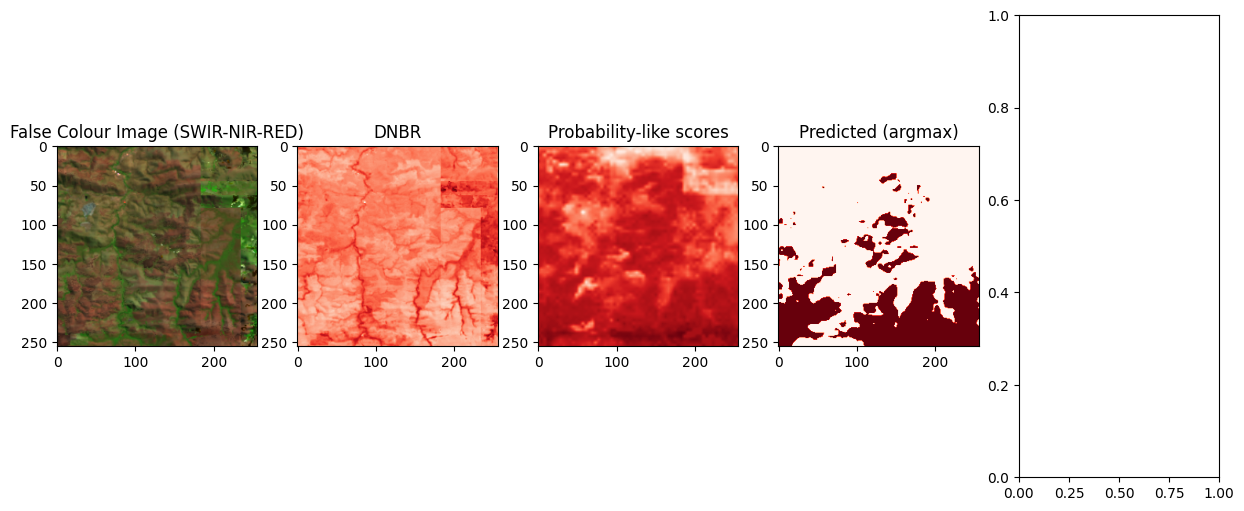

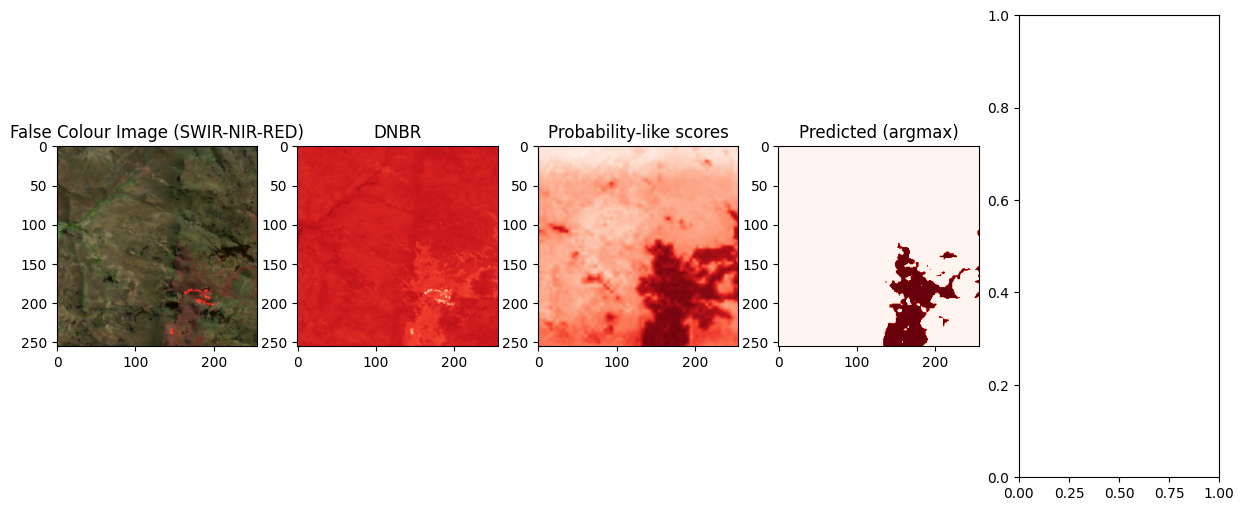

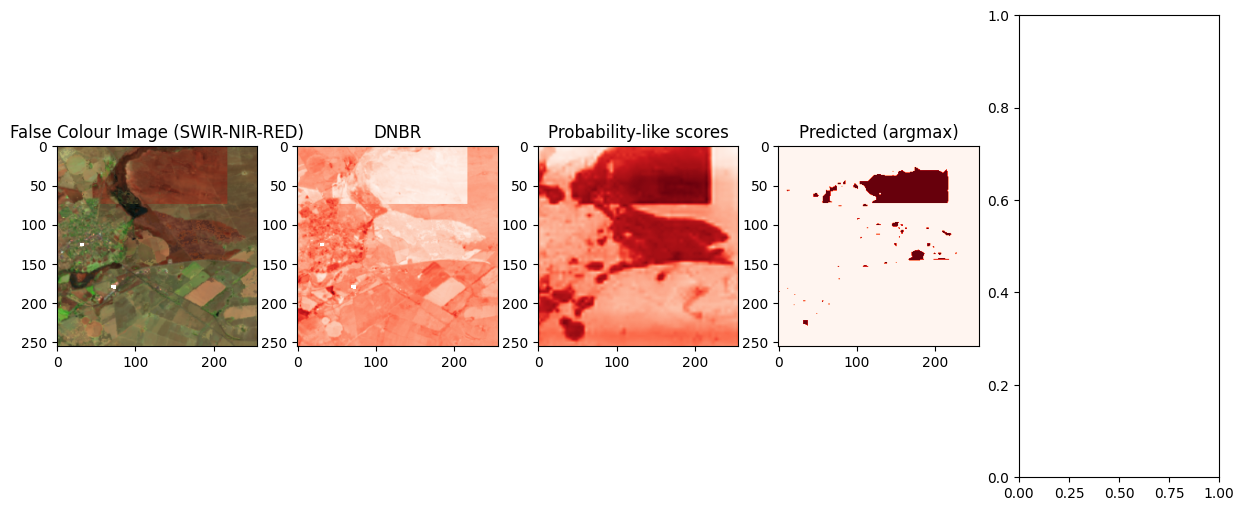

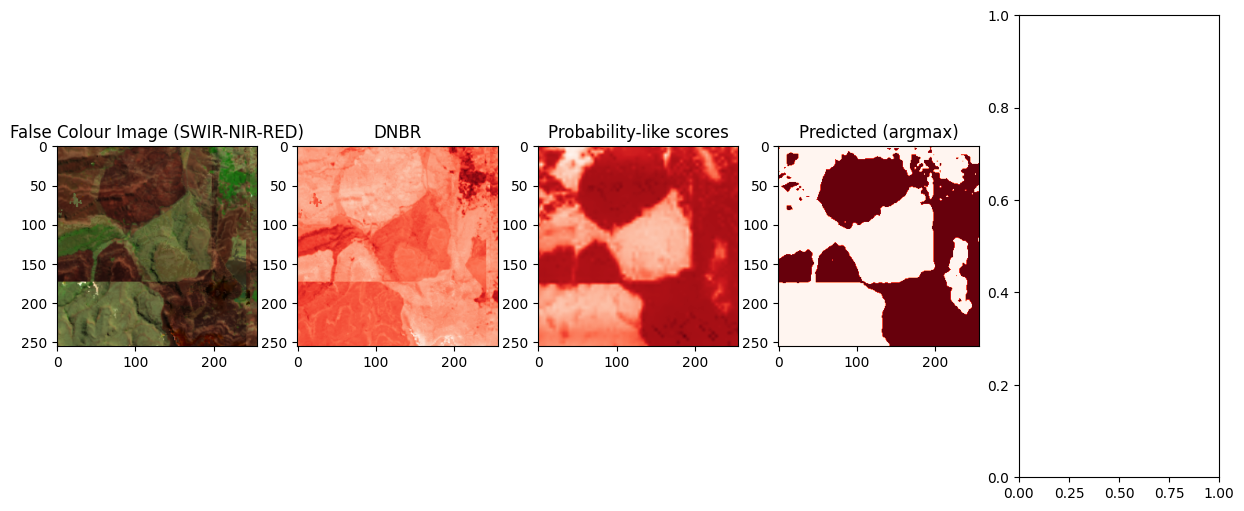

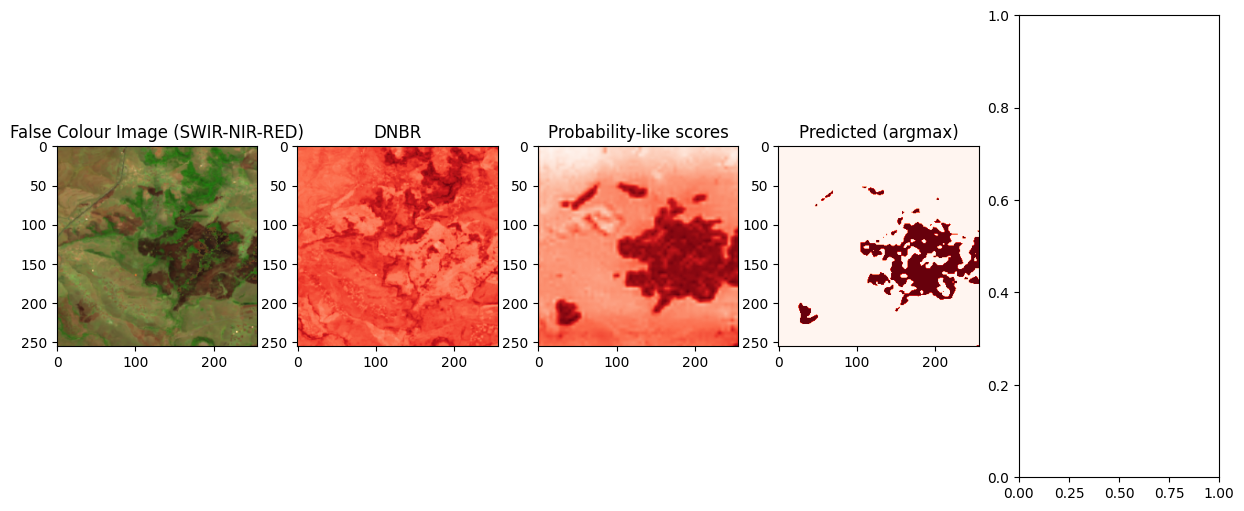

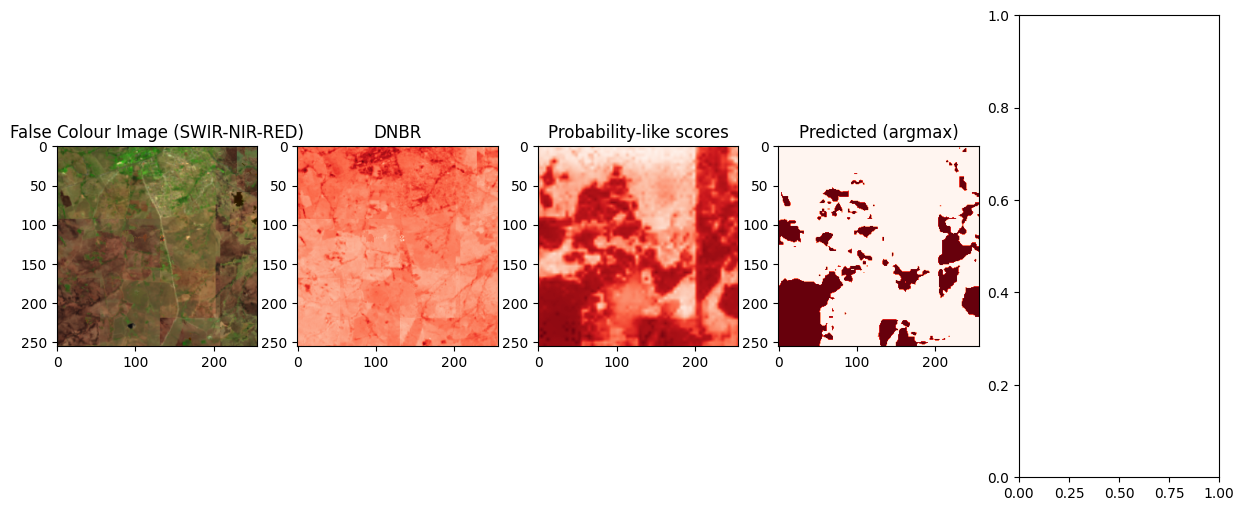

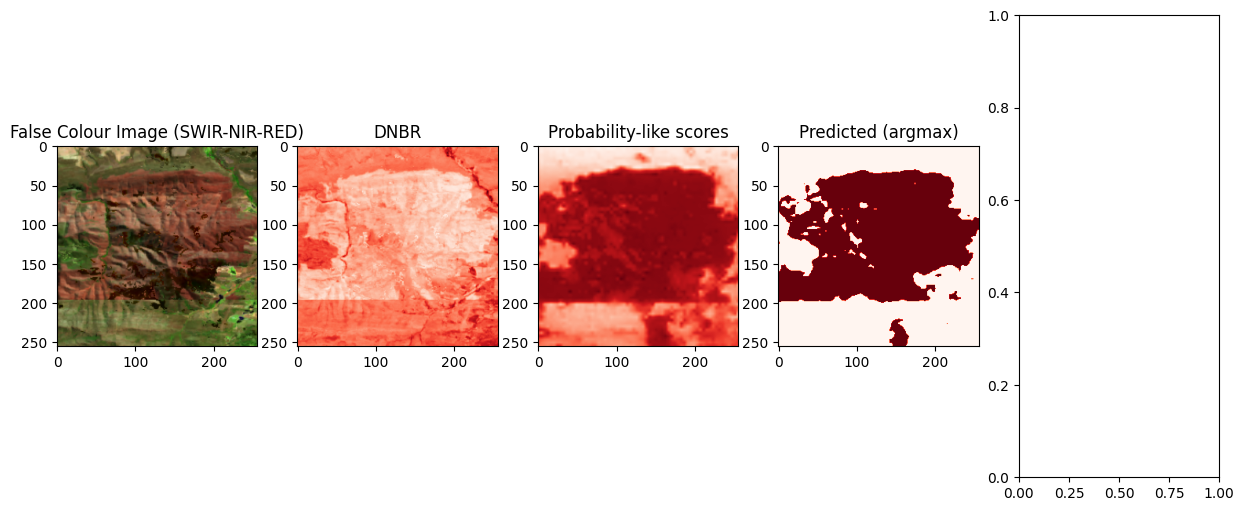

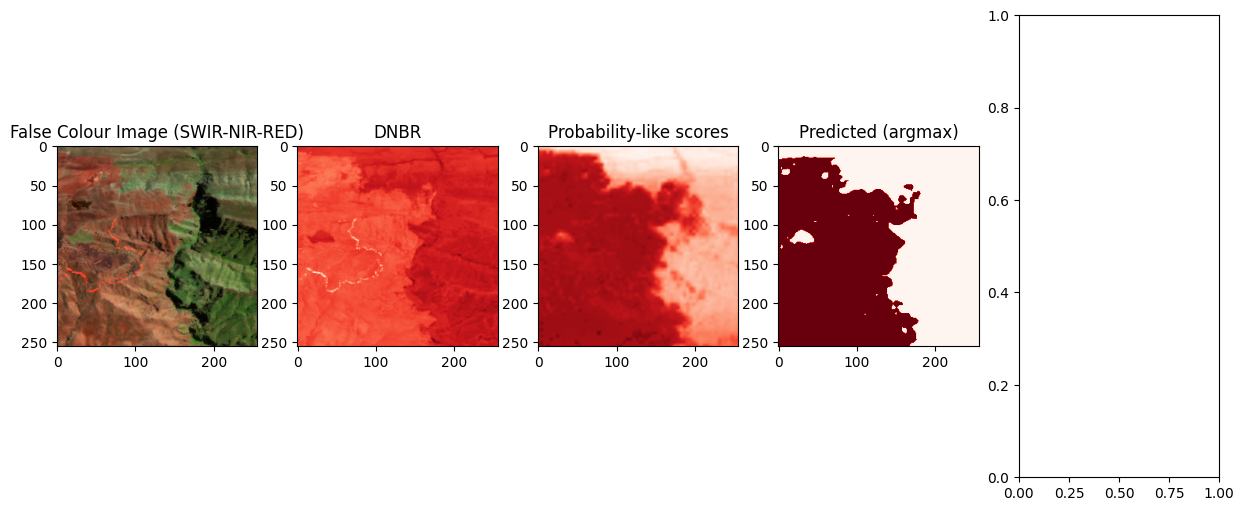

In [10]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[5, 3, 2],:,:].cpu().numpy()*2
        # mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,6,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the reference mask
        # axs[4].imshow(mask.squeeze(), cmap='Reds')
        # axs[4].set_title(labels[4])

batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)

out = model(torch.nan_to_num(inB, nan = 0.0, posinf = 0.0, neginf = 0.0))
plot_batch_preds(batch)

In [2]:
# Prepare data
import os
import shutil
import rasterio
from tqdm.auto import tqdm
import random

def copy_projection_and_sort(
    masks_folder: str, 
    images_folder: str, 
    train_folder: str, 
    test_folder: str, 
    test_ratio: float = 0.2
) -> None:
    """
    Copies projection information from images in `images_folder` to matching masks in `masks_folder` 
    based on matching names after the first underscore. Then, copies both masks and images to 
    train or test folders.

    Args:
        masks_folder (str): Path to the folder containing mask TIFF files.
        images_folder (str): Path to the folder containing image TIFF files.
        train_folder (str): Path to the folder where train images and masks will be stored.
        test_folder (str): Path to the folder where test images and masks will be stored.
        test_ratio (float, optional): Proportion of files to copy to the test folder. Defaults to 0.2.
    """
    # Ensure train and test folders exist for both X (images) and Y (masks)
    os.makedirs(os.path.join(train_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'Y'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'Y'), exist_ok=True)

    # List all mask files in the masks folder
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.tif')]
    
    # Randomize the order of files to ensure better train-test split
    random.shuffle(mask_files)
    
    for mask_file in tqdm(mask_files, desc="Processing masks"):
        # Get the part of the mask filename after the first underscore
        mask_id = mask_file.split('_', 1)[1]

        # Try to find the corresponding image in the images folder
        matching_images = [f for f in os.listdir(images_folder) if mask_id in f]
        if not matching_images:
            print(f"No matching image found for {mask_file}. Skipping...")
            continue

        image_file = matching_images[0]  # Assuming the first match is the correct one

        # Read the projection information from the image file
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        with rasterio.open(image_path) as src_image:
            image_crs = src_image.crs
            image_transform = src_image.transform

        # Copy the mask file with updated projection information
        with rasterio.open(mask_path, 'r+') as dst_mask:
            dst_mask.crs = image_crs
            dst_mask.transform = image_transform

        # Determine if the file goes into train or test set based on test_ratio
        if random.random() < test_ratio:
            dest_folder = test_folder
        else:
            dest_folder = train_folder

        # Copy both the mask and the corresponding image to the destination folder
        shutil.copy(mask_path, os.path.join(dest_folder, 'Y', mask_file))
        shutil.copy(image_path, os.path.join(dest_folder, 'X', image_file))


# Example usage:

# maskPath = r"/home/geethen/fire/data/DNN/toLabel/irisLabels"
# imagePath = r"/home/geethen/fire/data/DNN/toLabel/X_chips"
# trainFolder = r"/home/geethen/fire/data/DNN/toLabel/L8ft/train"
# testFolder = r"/home/geethen/fire/data/DNN/toLabel/L8ft/test"

maskPath = r'/home/geethen/fire/data/DNN/GABAM_L8/Y_chips'
imagePath = r'/home/geethen/fire/data/DNN/GABAM_L8/X_chips'
trainFolder = r'/home/geethen/fire/data/DNN/GABAM_L8/train'
testFolder = r'/home/geethen/fire/data/DNN/GABAM_L8/test'
copy_projection_and_sort(maskPath, imagePath, trainFolder, testFolder, 0.15)

Processing masks:   0%|          | 0/8666 [00:00<?, ?it/s]

In [3]:
import os
from pathlib import Path

def compare_and_delete_tif_images(directory, delete_unmatched=False):
    # Get the paths for subdirectories X and Y
    x_path = Path(directory) / 'X'
    y_path = Path(directory) / 'Y'
    
    # Check if both subdirectories exist
    if not (x_path.is_dir() and y_path.is_dir()):
        raise ValueError("Both subdirectories X and Y must exist in the given directory.")
    
    # Get lists of .tif files in both directories
    x_files = set(f.name for f in x_path.glob('*.tif'))
    y_files = set(f.name for f in y_path.glob('*.tif'))
    
    # Function to get the matching part of the filename
    def get_matching_part(filename):
        return '_'.join(filename.split('_')[1:])
    
    # Create sets of matching parts for both directories
    x_matching_parts = set(get_matching_part(f) for f in x_files)
    y_matching_parts = set(get_matching_part(f) for f in y_files)
    
    # Find unmatched files
    unmatched_x = [f for f in x_files if get_matching_part(f) not in y_matching_parts]
    unmatched_y = [f for f in y_files if get_matching_part(f) not in x_matching_parts]
    print(unmatched_x, unmatched_y)
    print(len(unmatched_x), len(unmatched_y))
    
    # Delete unmatched files if delete_unmatched is True
    if delete_unmatched:
        for file in unmatched_x:
            (x_path / file).unlink()
        for file in unmatched_y:
            (y_path / file).unlink()
        print(f"Deleted {len(unmatched_x)} unmatched files from X and {len(unmatched_y)} unmatched files from Y.")
    
    return {
        'unmatched_in_X': unmatched_x,
        'unmatched_in_Y': unmatched_y
    }

# Example usage:
# root_dir = r'/home/geethen/fire/data/DNN/toLabel/L8ft/train'
root_dir = r'/home/geethen/fire/data/DNN/GABAM_L8/train'
compare_and_delete_tif_images(root_dir, True)

# root_dir = r'/home/geethen/fire/data/DNN/toLabel/L8ft/test'
root_dir = r'/home/geethen/fire/data/DNN/GABAM_L8/test'
compare_and_delete_tif_images(root_dir, True)

['image_2760_0_0.tif', 'image_3148_0_0.tif', 'image_3311_0_0.tif', 'image_1435_0_0.tif', 'image_2451_0_0.tif', 'image_2267_0_0.tif', 'image_3175_0_0.tif', 'image_3450_0_0.tif', 'image_1466_0_0.tif', 'image_1733_0_0.tif', 'image_3218_0_0.tif', 'image_2603_0_0.tif', 'image_1870_256_256.tif', 'image_1579_0_0.tif', 'image_1578_0_0.tif', 'image_3665_0_0.tif', 'image_1432_0_0.tif', 'image_3162_0_0.tif', 'image_2181_0_0.tif', 'image_548_0_0.tif', 'image_2860_0_0.tif', 'image_1991_0_0.tif', 'image_1999_0_0.tif', 'image_2843_0_0.tif', 'image_2632_0_0.tif', 'image_2198_0_0.tif', 'image_1710_0_0.tif', 'image_1917_0_0.tif', 'image_2015_0_0.tif', 'image_2344_0_0.tif', 'image_3333_0_0.tif', 'negimage_3176_0_0.tif', 'image_1294_0_0.tif', 'image_3149_0_0.tif', 'image_2727_0_0.tif', 'image_2684_0_0.tif', 'image_2550_0_0.tif', 'image_1722_0_0.tif', 'image_1814_0_0.tif', 'image_2274_0_0.tif', 'image_2673_0_0.tif', 'image_2788_0_0.tif', 'image_2610_0_0.tif', 'image_1754_0_0.tif', 'image_1457_0_0.tif', 'im

{'unmatched_in_X': ['negimage_3207_0_0.tif',
  'negimage_3092_0_0.tif',
  'image_1294_0_0.tif',
  'image_1877_0_0.tif',
  'negimage_3313_0_0.tif',
  'image_3708_0_0.tif',
  'image_2612_0_0.tif',
  'negimage_1127_0_0.tif',
  'image_2658_0_256.tif',
  'negimage_2128_0_0.tif',
  'image_528_0_0.tif',
  'image_1297_0_0.tif',
  'image_1341_0_0.tif',
  'image_2906_0_0.tif',
  'image_1465_0_0.tif',
  'negimage_1551_0_0.tif',
  'negimage_3425_0_0.tif',
  'negimage_1446_0_0.tif',
  'negimage_3392_0_0.tif',
  'image_698_0_0.tif',
  'negimage_3571_0_0.tif',
  'image_1701_0_0.tif',
  'negimage_1308_0_0.tif',
  'image_1987_0_0.tif',
  'image_3582_0_0.tif',
  'image_2310_0_0.tif',
  'image_1301_0_0.tif',
  'negimage_1393_0_0.tif',
  'image_2550_0_0.tif',
  'image_3630_0_0.tif',
  'image_3596_0_0.tif',
  'negimage_1516_0_0.tif',
  'negimage_3251_0_0.tif',
  'image_2764_0_0.tif',
  'negimage_1910_0_0.tif',
  'negimage_1720_0_0.tif',
  'negimage_2564_0_0.tif',
  'negimage_249_0_0.tif',
  'negimage_2396_

In [4]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
directory = r"/home/geethen/fire/data/DNN/toLabel/L8ft/test/X"
process_images(directory)
directory = r"/home/geethen/fire/data/DNN/toLabel/L8ft/train/X"
process_images(directory)

Processing images:   0%|          | 0/31 [00:00<?, ?it/s]

Processing images:   0%|          | 0/155 [00:00<?, ?it/s]

In [1]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from typing import Iterable, List, Optional, Callable

from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchseg
from typing import Dict 
import wandb

import schedulefree


In [2]:
from typing import Dict 
import wandb

def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    train_tfms: Optional[Callable]=None,
    val_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.train()
        optimizer.train()
        accum_loss = 0
        
        with tqdm(total= len(train_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

            for batch in train_dl:
                if train_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(train_tfms, list):
                                batch = [tfm(batch) for tfm in train_tfms][0]
                            else:
                                batch = train_tfms(batch)

                X = batch['image'].to(device)
                y = batch['mask'].type(torch.long).to(device)
                pred = model(torch.nan_to_num(X, nan = 0.0, posinf = 0.0, neginf = 0.0))
                loss = loss_fn(pred, y)
                
                # BackProp
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the accum loss
                accum_loss += float(loss) / len(train_dl)
                
                pbar.set_postfix(loss=f"{accum_loss:.4f}")
                pbar.update(1)
        
        wandb.log({"train_loss": accum_loss})

        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                with tqdm(total= len(val_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

                    for batch in val_dl:

                        if val_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(val_tfms, list):
                                batch = [tfm(batch) for tfm in val_tfms][0]
                            else:
                                batch = val_tfms(batch)                    

                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].type(torch.long).to(device)

                        pred = model(torch.nan_to_num(X, nan = 0.0, posinf = 0.0, neginf = 0.0))
                        val_loss = loss_fn(pred, y)
                        accum_val_loss += float(val_loss)/len(val_dl)

                        for i, acc_fn in enumerate(acc_fns):
                            acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))
                        
                        pbar.set_postfix(val_loss=f"{accum_val_loss:.4f}", val_acc=f"{acc[0]:.4f}", val_iou=f"{acc[1]:.4f}")
                        pbar.update(1)

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.metric_index]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.save_model_path)
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        wandb.log({"val_loss": accum_val_loss, "val_acc": acc[0], "val_iou": acc[1]})
    wandb.finish()

In [3]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential

class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch=True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor (nSamples, Channels, Height, Width)
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input (with tiling applied to each sample)
        """
        n_samples, channels, height, width = input.shape
        # Prepare a list to store the transformed samples
        transformed_samples = []
        
        # Loop over each sample in the batch
        for sample in input:
            np_array = sample.cpu().numpy()  # Convert sample to NumPy format
            sample_tiled = FlipnSlide(
                tile_size=flags['tilesize'], 
                data_type='tensor',
                save=False, 
                image=np_array,
                viz=flags['viz']
            )
            # Collect the transformed sample (converted back to tensor)
            transformed_samples.append(sample_tiled.tiles.unsqueeze(0))

        transformed_samples = torch.cat(transformed_samples, dim=0)
        
        # Stack all transformed samples back into a batch
        return transformed_samples.view(-1, *transformed_samples.shape[2:])


# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=64, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=5, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDVI(index_nir=3, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

2025-03-18 13:40:11.778877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 13:40:11.789934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742305211.803813 3711196 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742305211.808002 3711196 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 13:40:11.822303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [ ]:
from torchgeo.samplers import PreChippedGeoSampler

# root = Path(r"/home/geethen/fire/data/DNN/toLabel/L8ft")
root = Path(r'/home/geethen/fire/data/DNN/GABAM_L8')
assert root.exists()
train_imgs = RasterDataset(paths=(root/'train/X').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train/Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test/X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test/Y').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = PreChippedGeoSampler(train_imgs)
# valid_sampler = PreChippedGeoSampler(valid_imgs)

# train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 165, units=Units.PIXELS)#667#168
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 1095, units=Units.PIXELS)#287#34

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 16, collate_fn=stack_samples, num_workers=14, pin_memory=True, prefetch_factor=4, persistent_workers=True)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 16, collate_fn=stack_samples, num_workers=14, pin_memory=True, prefetch_factor=4, persistent_workers=True)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

In [6]:
device = "cuda:0" if torch.cuda.is_available() else 'cpu'

model = smp.Segformer(encoder_name='mit_b4', encoder_weights=None, in_channels = 11,classes=2)
model = model.to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/segformer_p5c2_05022025.pth")
# checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_FL_r1_21022025.pth")

model.load_state_dict(checkpoint)
model.eval()


/tmp/ipykernel_3711196/1789435670.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(11, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_featu

In [ ]:
# Initialize wandb
wandb.init(project="burn_area_mapping", name="segformer_sagabamft_r1_18032025", job_type='L8_GB_finetuning_saeon')
# Define hyperparameters
config = wandb.config
config.learning_rate = 0.0025
config.epochs = 300
config.metric_index = 1
config.save_model_path = r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_gabam_r1_18032025.pth"
loss_fn = smp.losses.FocalLoss(mode= 'multiclass')#smp.losses.LovaszLoss(mode= 'multiclass')#

# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr= config.learning_rate)

# Freeze encoder weights
# for param in model.encoder.parameters():
#     param.requires_grad = False

# Check if the encoder parameters are frozen
# for name, param in model.encoder.named_parameters():
#     print(f"{name} requires_grad: {param.requires_grad}")

train_loop(epochs = config.epochs, train_dl = train_dataloader, val_dl= valid_dataloader, model = model,
            loss_fn = loss_fn, optimizer = optimizer, 
            acc_fns=[oa, iou], train_tfms= [tfms_img, tfms_fns], val_tfms = tfms_img, train_params = config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: singhg10. Use `wandb login --relogin` to force relogin



Epoch 1/300


  0%|          | 0/225 [00:00<?, ?it/s]

In [5]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0
0
0


In [1]:
import torch
import segmentation_models_pytorch as smp
import torchseg
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = "cuda:1" if torch.cuda.is_available() else 'cpu'

model = smp.Segformer(encoder_name='mit_b4', encoder_weights=None, in_channels = 11,classes=2)
model = model.to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_gabam_r1_01032025.pth")
# checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/segformer_p5c2_05022025.pth")
# checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/segformer_p1_24012025.pth")

model.load_state_dict(checkpoint)
model.eval()

modelft2 = smp.Segformer(encoder_name='mit_b4', encoder_weights=None, in_channels = 11,classes=2)
modelft2 = modelft2.to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_gabam_r1_18032025.pth")
# checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_FL_r1c_21022025.pth")
# checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/saft_segformer_FL_r1_27012025.pth")

modelft2.load_state_dict(checkpoint)
modelft2.eval()

# Load pre-trained model
modelun = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=11,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/DL_imgnet_convnextT_16012025.pth")

modelun.load_state_dict(checkpoint)
modelun.eval()

# Load pre-trained model
modelft = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=11,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts/DL_saft_convnextT_FL_r5_22012025.pth")

modelft.load_state_dict(checkpoint)
modelft.eval()

/tmp/ipykernel_3788378/3754529584.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"/home/geethen/fire/Burn_Area_Mapping/src/components/artifacts

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(11, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [5]:
from pathlib import Path
root = Path(r"/home/geethen/fire/data/DNN/toLabel/L8ft")
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test/X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'test/Y').as_posix(), crs='epsg:4326', res= 0.00025)
root2 = Path(r'/home/geethen/fire/data/DNN/toLabel')
valid_msks = RasterDataset(paths=(root2/'altY_chips').as_posix(), crs='epsg:4326', res= 0.00025)

# valid_imgs = RasterDataset(paths=(root/'train/X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'train/Y').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 50, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=5, index_nir=3),
    indices.AppendNDWI(index_green=1, index_nir=3),
    indices.AppendNDVI(index_nir=3, index_red=2),
    data_keys = ['image']
)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

In [6]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 7, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Segformer', 'SegFormer FT','Pretrain Pred (UNet)', 'Pred (UNet) FT', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[5, 3, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,6,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[2].imshow(pred_mask, cmap='Reds')
        axs[2].set_title(labels[2])

        # plot the predicted mask
        pred_mask = np.argmax(outft2[idx].detach().cpu().numpy(), axis=0)#[0,:,:]
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(outun[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        pred_mask = np.argmax(outft[idx].detach().cpu().numpy(), axis=0)
        axs[5].imshow(pred_mask, cmap='Reds')
        axs[5].set_title(labels[5])

        # plot the reference mask
        axs[6].imshow(mask.squeeze(), cmap='Reds')
        axs[6].set_title(labels[6])

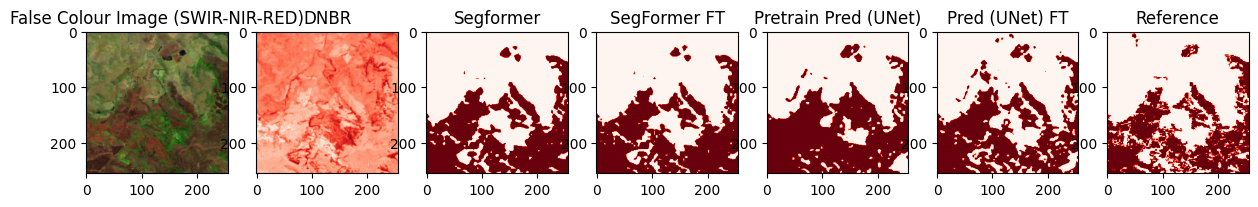

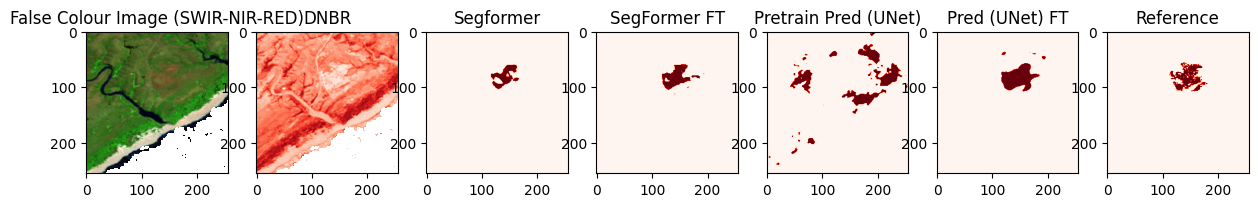

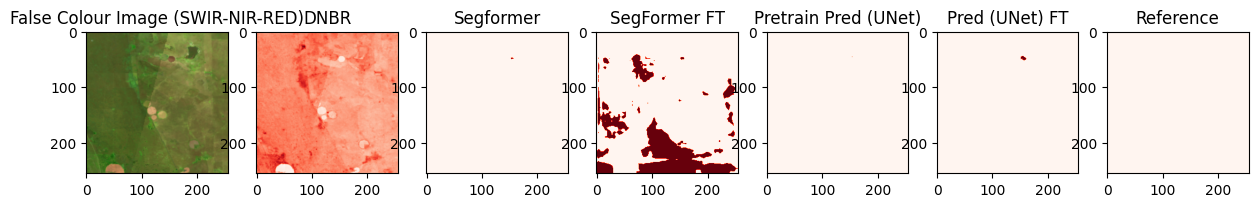

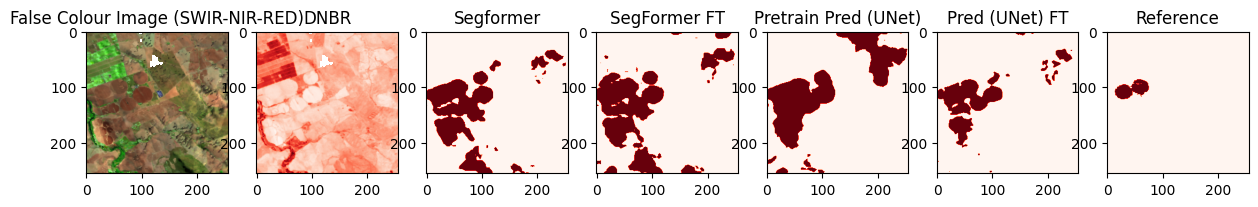

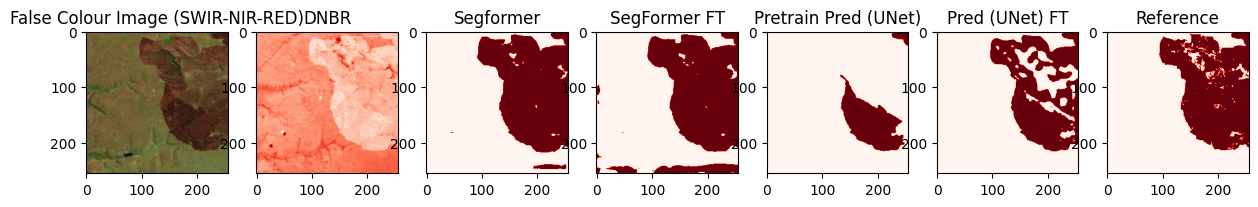

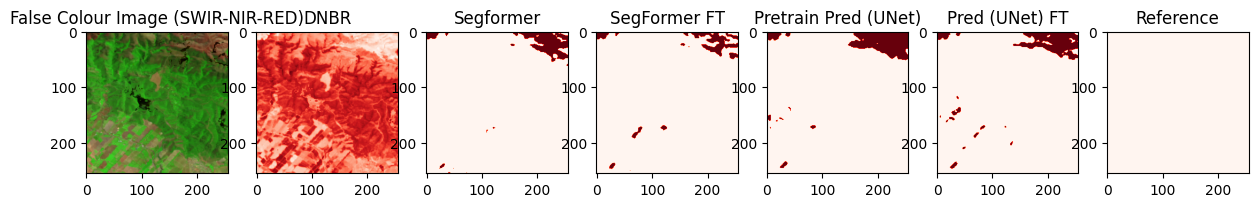

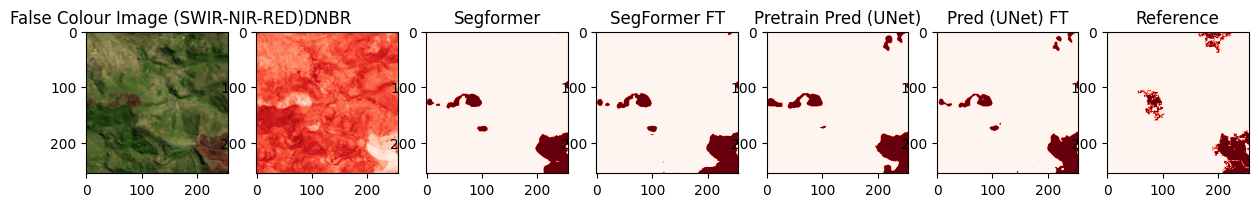

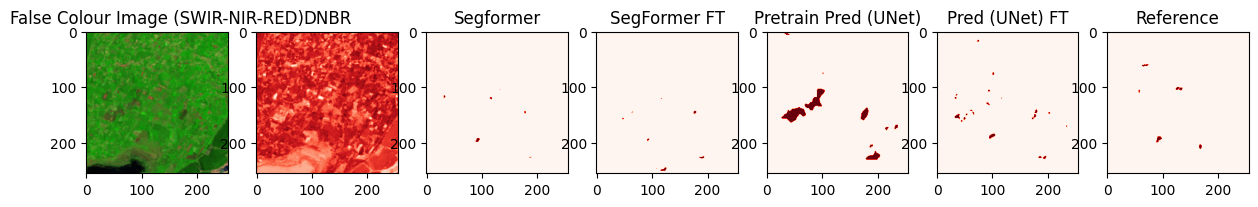

In [13]:
batch = next(iter(valid_dataloader))
inB = torch.nan_to_num(tfms_img(batch)['image']).to(device)

out = model(inB)
outft2 = modelft2(inB)
outun = modelun(inB)
outft = modelft(inB)

plot_batch_preds(batch)